# Research of advertisements of apartments for sale

Data used: the data of the Yandex.Realty service - an archive of ads for the sale of apartments in St. Petersburg and neighboring settlements for several years.\

Task: We need to learn how to determine the market value of real estate. The job is to set the parameters. This will allow to build an automated system: it will track anomalies and fraudulent activity.

Two types of data are available for each apartment for sale. The first ones are entered by the user, the second ones are obtained automatically on the basis of cartographic data. For example, the distance to the center, airport, nearest park and body of water.

### Opening file and studying general information.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

We see a lot of lines containing nulls.

In [3]:
with pd.option_context('display.max_columns', 50):
    print (data.head(10))

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0      108.00  2019-03-07T00:00:00      3   
1             7   3350000.0       40.40  2018-12-04T00:00:00      1   
2            10   5196000.0       56.00  2015-08-20T00:00:00      2   
3             0  64900000.0      159.00  2015-07-24T00:00:00      3   
4             2  10000000.0      100.00  2018-06-19T00:00:00      2   
5            10   2890000.0       30.40  2018-09-10T00:00:00      1   
6             6   3700000.0       37.30  2017-11-02T00:00:00      1   
7             5   7915000.0       71.60  2019-04-18T00:00:00      2   
8            20   2900000.0       33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.00  2017-02-26T00:00:00      3   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0        51.00      8          NaN   False   
1             NaN          11.0        18.60      1          NaN  

Combined with displaying information by columns and displaying the top 10 rows, you can see that not all columns are formatted correctly.

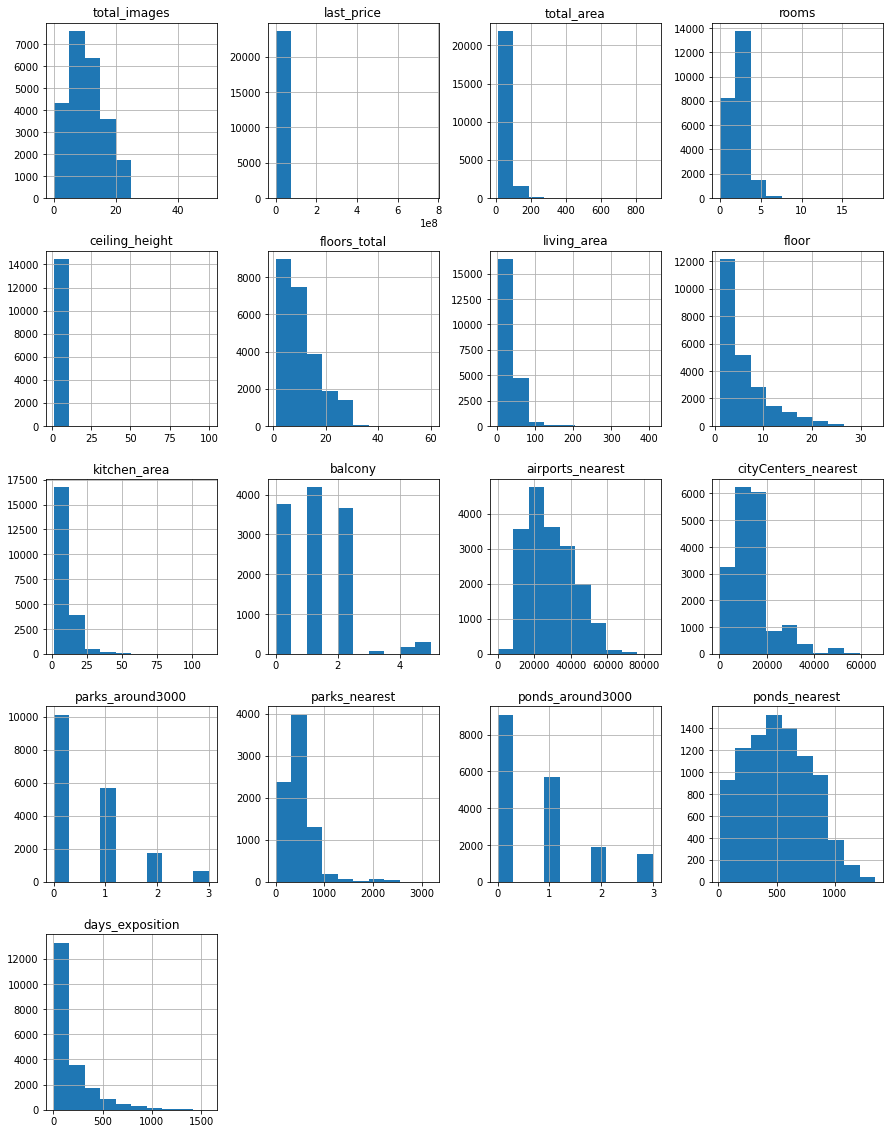

In [4]:
data.hist(figsize=(15, 20));

At first glance at the graphs, one can decide that all the values are within the normal range, but most likely this is not the case. We will need to check this in the future.

### Data transformation

#### Duplicates handling

In [5]:
print(data.duplicated().sum())

0


There are no absolute duplicates in the table. But it is quite possible that this is due to single differences in the cells.

In [6]:
print(data['locality_name'].value_counts())

Санкт-Петербург            15721
посёлок Мурино               522
посёлок Шушары               440
Всеволожск                   398
Пушкин                       369
                           ...  
деревня Хапо-Ое                1
посёлок Плоское                1
деревня Малая Романовка        1
посёлок Шугозеро               1
поселок Гаврилово              1
Name: locality_name, Length: 364, dtype: int64


It is possible that the names are duplicated. This could have been avoided if there had been an additional postcode column.

Duplicates need to be removed:
1) Replace 'Ё' with 'Е'
2) remove the "village" or display it in a separate column City / Village. If we had a chance, we would inquire Subject Matter Expert (hereinafter SME) to give us guidance\
3) make any other corrections of duplicates

In [7]:
print(data['locality_name'].value_counts())

Санкт-Петербург            15721
посёлок Мурино               522
посёлок Шушары               440
Всеволожск                   398
Пушкин                       369
                           ...  
деревня Хапо-Ое                1
посёлок Плоское                1
деревня Малая Романовка        1
посёлок Шугозеро               1
поселок Гаврилово              1
Name: locality_name, Length: 364, dtype: int64


In [8]:
print(list(data['locality_name'].sort_values().unique()))
data['locality_name'] = data['locality_name'].str.replace('ё','е')
data['locality_name'] = data['locality_name'].str.replace('городского типа ','')
data['locality_name'] = data['locality_name'].str.replace('коттеджный ','')
data['locality_name'] = data['locality_name'].str.replace('городской ','')
data['locality_name'] = data['locality_name'].str.replace('при железнодорожной ','')
data['locality_name'] = data['locality_name'].str.replace('имени ','')
data['locality_name'] = data['locality_name'].str.replace('некоммерческое ','')

['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг', 'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск', 'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар', 'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле', 'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское', 'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво', 'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург', 'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор', 'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург', 'городской поселок Большая Ижора', 'городской поселок Янино-1', 'городской посёлок Будогощь', 'городской посёлок Виллози', 'городской посёлок Лесогорский', 'городской посёлок Мга', 'городской посёлок Назия', 'городской посёлок Новоселье', 'городской посёлок Павлово', 'городской посёлок Рощино', 'городской посёлок Свирьстрой', 'городской посёлок Советский', 'городской посёлок Фёдоровское', 'городской посёлок Янино-1', 'деревня Агалатово', 'деревня Аро',

In [9]:
def categorized_locality_name(place):
    try:
        if 'поселок' in place or 'село' in place or 'деревня' in place or 'товарищество' in place:
            return False #Not city
        elif place.endswith('во') or place.endswith('но') or place.endswith('ко'):
            return False #Not city
        else:
            return True  #City
    except:
        pass
    
data['locality_type_city'] = data['locality_name'].apply(categorized_locality_name)
print(data['locality_type_city'].value_counts())

True     19163
False     4487
Name: locality_type_city, dtype: int64


We have created an additional column with auxiliary features. Some lines, such as Kudrovo, technically did not contain a description of a settlement, but almost everything ending in "o" is not a city. Therefore, the Kudrovo category without a prefix will be False - not a city. Let's check the conditions.

In [10]:
print(data.loc[data['locality_name'] == 'Кудрово', 'locality_type_city'].value_counts())

False    173
Name: locality_type_city, dtype: int64


The formula works as expected. We can go on with a complete cleaning of the names - as we have seen, some names have the prefix village and also do not have it in some lines. Therefore, it can be assumed that all such values are one locality.

In [11]:
data['locality_name'] = data['locality_name'].str.replace('поселок ','')
data['locality_name'] = data['locality_name'].str.replace('деревня ','')
print(data['locality_name'].value_counts())

Санкт-Петербург    15721
Мурино               590
Кудрово              472
Шушары               440
Всеволожск           398
                   ...  
Кивеннапа Север        1
Ялгино                 1
Кондратьево            1
Левашово               1
Счастье                1
Name: locality_name, Length: 310, dtype: int64


Implicit duplicates have been replaced - a village 'поселок' and a settlement 'село' are considered two different administrative units, so we won't remove the settlement. Let's check again if there are absolute duplicates.

In [12]:
print(data.duplicated().sum())

0


After clearing the values, there were no absolute duplicates - it means that the table most likely really consists of unique rows. In any case, even if there are 5% of duplicate rows of the total, this will not greatly affect the totals - only if the values do not fall out of the total.

#### NULLs handling

In [13]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
locality_type_city         49
dtype: int64


It can be seen that there are many gaps in the table. Most likely, many depend on each other, such as open_plan and kitchen_area. Let's check below.

#### Handling locality_name

We have already cleared the names in this column, but now we need to fill in the empty values with some conditional ones.

In [14]:
print(data[data['locality_name'].isna()])

       total_images  last_price  total_area first_day_exposition  rooms  \
1097              3   8600000.0       81.70  2016-04-15T00:00:00      3   
2033              6   5398000.0       80.00  2017-05-30T00:00:00      3   
2603             20   3351765.0       42.70  2015-09-20T00:00:00      1   
2632              2   5130593.0       62.40  2015-10-11T00:00:00      2   
3574             10   4200000.0       46.50  2016-05-28T00:00:00      2   
4151             17  17600000.0       89.50  2014-12-09T00:00:00      2   
4189              7   9200000.0       80.00  2015-12-10T00:00:00      3   
4670              1   5500000.0       83.00  2015-08-14T00:00:00      3   
5343             19  13540000.0       85.50  2016-01-20T00:00:00      3   
5707              7   3700000.0       30.00  2016-04-29T00:00:00      1   
6765             20   4895892.0       60.70  2015-03-12T00:00:00      2   
7114              5   4250000.0       56.00  2016-03-16T00:00:00      3   
7330              8   510

In [15]:
data['locality_name'] = data['locality_name'].fillna('Неизвестно')

#### Handling ceiling_height

count    14504.000000
mean         2.771499
std          1.261056
min          1.000000
25%          2.520000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64


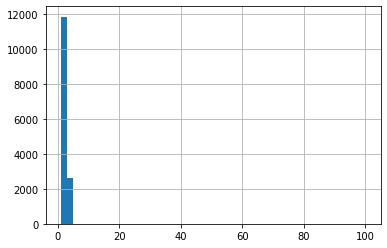

In [16]:
print(data['ceiling_height'].describe())
data['ceiling_height'].hist(bins = 50)
plt.show()

The spread of data does not seem to be high - all the main indicators are in the first half of 0-20. But there is also a maximum value of 100. You need to see how many values ​​are above the average.

In [17]:
print(data[data['ceiling_height'] > 5]['ceiling_height'].value_counts())

27.0     8
25.0     7
8.0      3
5.3      2
32.0     2
14.0     1
5.2      1
6.0      1
8.3      1
5.6      1
5.8      1
10.3     1
5.5      1
20.0     1
26.0     1
22.6     1
27.5     1
24.0     1
100.0    1
Name: ceiling_height, dtype: int64


It looks like there are errors, but there are also values, as if a person put a comma in the wrong place - mostly in double digits. The rest of the lines are non-standard. Let's divide the two-digit values above 20 by 10 (we'll remove the 100 later).

In [18]:
for row in data['ceiling_height']:
    if row >= 20:
        data['ceiling_height'] = data['ceiling_height'].replace(row, row/10)
print(data[data['ceiling_height'] > 5]['ceiling_height'].value_counts())

8.0     3
5.3     2
14.0    1
5.8     1
6.0     1
10.3    1
8.3     1
5.2     1
5.5     1
10.0    1
5.6     1
Name: ceiling_height, dtype: int64


We were able to correct wrongly entered data.\
Ceiling height is one of the standard values. On average, in Russian apartments, the ceiling height is approximately 3 meters. According to the information and the graph, the spread of values is quite strong - almost all values are grouped up to 10 meters. The column also has missing values.
We use the median to fill in empty values to avoid using the maximum and minimum values (1 meter and 100 meters).

In [19]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
print(data['ceiling_height'].isna().sum())

0


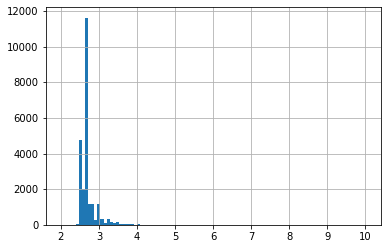

Number of rows with ceilings above 5 meters: 14


In [20]:
data['ceiling_height'].hist(bins = 100, range=(2,10))
plt.show()
print('Number of rows with ceilings above 5 meters:', data[data['ceiling_height'] > 5]['ceiling_height'].count())

With a decrease in the boundaries of the histogram and the second number of ceilings above 5 meters, we see that there are simply no values more than 5 meters in the amount we need. It also makes no sense to continue the analysis related to the height of the ceilings, with lines where the height of the ceiling is equal to the height of a very tall person. Therefore, we can continue to work only with those lines where the values are greater than 2 and less than 5, inclusive.

In [21]:
data = data[(data['ceiling_height'] > 2) & (data['ceiling_height'] <= 5)]
print(data['ceiling_height'].describe())

count    23670.000000
mean         2.696398
std          0.215216
min          2.200000
25%          2.600000
50%          2.650000
75%          2.700000
max          5.000000
Name: ceiling_height, dtype: float64


We corrected, filled in the gaps and removed the rows with deviant ceiling norms

#### Handling balcony

Most likely, the empty value of the balcony means its absence. Therefore, you can replace the nulls with 0.

In [22]:
data['balcony'] = data['balcony'].fillna(0)
print(data['balcony'].isna().sum())

0


#### Handling total_area

count    23670.000000
mean        60.316745
std         35.522659
min         12.000000
25%         40.000000
50%         52.000000
75%         69.875000
max        900.000000
Name: total_area, dtype: float64


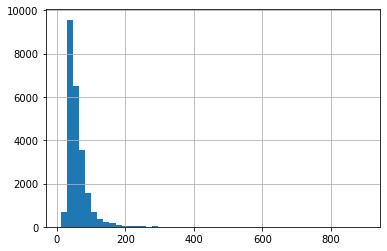

In [23]:
print(data['total_area'].describe())
data['total_area'].hist(bins = 50)
plt.show()

As we can see, there are practically no values ​​over 300 m2 - let's check the values together with kitchen_area, living_area and last_price.

In [24]:
print(data[data['total_area'] > 300].groupby('total_area').agg({'living_area':['sum'], 'kitchen_area':['sum'],'total_area':['count', 'sum'], 'last_price':['sum']}))

           living_area kitchen_area total_area            last_price
                   sum          sum      count      sum          sum
total_area                                                          
301.90           163.2        20.40          1   301.90   30000000.0
304.00             0.0         0.00          1   304.00  130278280.0
307.80           187.9        63.40          1   307.80  130000000.0
309.70           199.0        14.30          1   309.70   19500000.0
310.00           250.0        50.00          1   310.00  135000000.0
312.00           321.0        65.00          2   624.00   63900000.0
313.00           179.2        13.20          1   313.00   23500000.0
315.00           182.0        37.00          1   315.00   40000000.0
316.30           187.0         0.00          1   316.30   24000000.0
317.00           183.0         0.00          1   317.00   96000000.0
320.00           190.0        28.00          1   320.00   14000000.0
323.00           255.7        66.0

The cost of apartments coincides with the total area - so these are not errors in the data. But in order to clean up the data, in principle, they can be deleted - there are less than 90 lines over 300 m2 (they are shown completely on the screen), and although their removal will not greatly affect the medians and so on, their absence will allow us to filter future graphs less.

count    23609.000000
mean        59.422545
std         30.422668
min         12.000000
25%         40.000000
50%         52.000000
75%         69.400000
max        297.500000
Name: total_area, dtype: float64


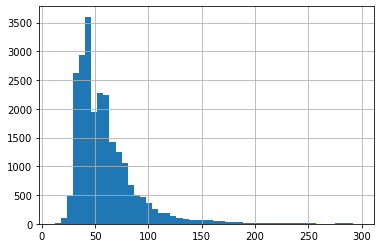

In [25]:
data = data[data['total_area'] < 300]
print(data['total_area'].describe())
data['total_area'].hist(bins = 50)
plt.show()

#### Handling living_area

Although the values in total_area are completely filled, the values in living_area are not everywhere. It is difficult to correlate between this and other columns, so two methods can be applied:
1) if there are kitchen and balcony values, then they can be used to calculate the living area, and the remaining empty values can be filled with medians, but only if the kitchen_area is filled. Minus - the living area will also include a toilet and utility rooms;\
2) either create groups and fill in the values with the median differences of non-empty values inside the group total_area\
Before that, we need to check if the open_plan column will affect the result.

In [26]:
print(data['open_plan'].value_counts())

False    23543
True        66
Name: open_plan, dtype: int64


This column doesn't seem to have any effect on living_area numbers - there are only 66 open-plan apartments.

In [27]:
print(data['living_area'].describe())
print(data['living_area'].isna().sum())

count    21722.000000
mean        34.014849
std         19.791854
min          2.000000
25%         18.600000
50%         30.000000
75%         42.200000
max        250.000000
Name: living_area, dtype: float64
1887


The dispersion of living_area is strong, but not as much as in total_area. Since total_area is available to us completely for all lines, we can categorize it and fill living_area with median values within the group without regard to the possibility of free planning.

In [28]:
def categorized_total_area(area):
    try:
        if 0 < area <= 20:
            return 10
        elif 20 < area <= 35:
            return 9
        elif 35 < area <= 45:
            return 8
        elif 45 < area <= 55:
            return 7
        elif 55 < area <= 65:
            return 6
        elif 65 < area <= 80:
            return 5
        elif 90 < area <= 120:
            return 4
        elif 120 < area <= 150:
            return 3
        elif 150 < area <= 200:
            return 2
        else:
            return 1
    except:
        pass

In [29]:
data['total_area_categories'] = data['total_area'].apply(categorized_total_area)
print(data.loc[:,['total_area','total_area_categories','living_area']].sort_values(by='living_area'))

       total_area  total_area_categories  living_area
13915       52.00                      7          2.0
21758       23.00                      9          2.0
23574      139.00                      3          3.0
3242        41.00                      8          3.0
17582       22.00                      9          5.0
...           ...                    ...          ...
23642       80.30                      1          NaN
23663       88.00                      1          NaN
23670       45.60                      7          NaN
23679       35.00                      9          NaN
23697       76.75                      5          NaN

[23609 rows x 3 columns]


The categorization works correctly. Now, before filling living_area with medians, you need to check the medians of living_area by groups of total_area - to compare with the final result of filling - and also display at least one line with empty values ​​to get an index and see the work of future categorization.

In [30]:
print(data.groupby('total_area_categories')['living_area'].median())
print(data.loc[data['living_area'].isna(), ['total_area_categories', 'living_area']].head(1))

total_area_categories
1     51.50
2     99.05
3     78.00
4     59.00
5     43.10
6     36.00
7     29.70
8     19.00
9     17.00
10    13.50
Name: living_area, dtype: float64
   total_area_categories  living_area
3                      2          NaN


In [31]:
area_categories = data['total_area_categories'].unique()

for category in area_categories:
    group_median = data.loc[data['total_area_categories'] == category, 'living_area'].median()
    data.loc[data['total_area_categories'] == category,'living_area'] = data.loc[data['total_area_categories'] == category, 'living_area'].fillna(group_median)

print(data['living_area'].describe())
print(data['living_area'].isna().sum())
print(data['living_area'][3])

count    23609.000000
mean        34.004962
std         19.622682
min          2.000000
25%         19.000000
50%         30.000000
75%         42.500000
max        250.000000
Name: living_area, dtype: float64
0
99.05


We were able to replace the gaps with the medians within the group - checked against the index, checked for the presence of gaps after processing, and checked the preservation of medians and averages.

#### Handling kitchen_area

Let's fill in the kitchen_area column in the same way as living_area.

In [32]:
print(data.groupby('total_area_categories')['kitchen_area'].median())
print(data.loc[data['kitchen_area'].isna(), ['total_area_categories', 'kitchen_area']].head(1))

total_area_categories
1     12.70
2     19.50
3     17.03
4     14.40
5     10.40
6      9.00
7      8.20
8      9.00
9      7.00
10     3.00
Name: kitchen_area, dtype: float64
   total_area_categories  kitchen_area
3                      2           NaN


In [33]:
print('Before filling:')
print(data['kitchen_area'].describe())
for category in area_categories:
    group_median = data.loc[data['total_area_categories'] == category, 'kitchen_area'].median()
    data.loc[data['total_area_categories'] == category,'kitchen_area'] = data.loc[data['total_area_categories'] == category, 'kitchen_area'].fillna(group_median)

print('After filling:')
print(data['kitchen_area'].describe())
print(data['kitchen_area'].isna().sum())
print(data['kitchen_area'][3])

Before filling:
count    21350.000000
mean        10.505725
std          5.673082
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64
After filling:
count    23609.000000
mean        10.381448
std          5.469464
min          1.300000
25%          7.000000
50%          9.000000
75%         11.700000
max        107.000000
Name: kitchen_area, dtype: float64
0
19.5


#### Handling is_apartment

The last column with values that can be populated is is_apartment.

In [34]:
print(data['is_apartment'].isna().sum())
print(data['is_apartment'].value_counts())

20843
False    2718
True       48
Name: is_apartment, dtype: int64


The apartment format is not popular in Russia - as we can see from the information above, there are 48 cells filled with True. Therefore, empty values ​​can be filled with False.

In [35]:
data['is_apartment'] = data['is_apartment'].fillna(False)
print(data['is_apartment'].value_counts())

False    23561
True        48
Name: is_apartment, dtype: int64


#### Handling floor_total

The number of floors depends on the average number of storeys in the city - in St. Petersburg, the average height of a building can be 10 floors, while in the village - 1. Thus, the voids in the total number of storeys can be filled either by the median indicators for the most populated area, or by the median values of types of settlements.

In [36]:
print('Medians by location;',data.groupby('locality_name')['floors_total'].median().sort_values())
print('Medians by type of location;',data.groupby('locality_type_city')['floors_total'].median())

Medians by location; locality_name
Свирьстрой         1.0
Сижно              1.0
Каськово           1.0
Пчевжа             1.0
Лисий Нос          2.0
                  ... 
Бугры             17.0
Петро-Славянка    18.0
Кудрово           18.0
Мурино            19.0
Парголово         25.0
Name: floors_total, Length: 311, dtype: float64
Medians by type of location; locality_type_city
False    9.0
True     9.0
Name: floors_total, dtype: float64


We see that with medians by type of location, the value is too average. Therefore, it would be better to try filling by location.

In [37]:
localities = data['locality_name'].unique()
print('Nulls before filling by locations',data['floors_total'].isna().sum())
print(data['floors_total'].describe())

for category in localities:
    group_median = data.loc[data['locality_name'] == category, 'floors_total'].median()
    data.loc[data['locality_name'] == category,'floors_total'] = data.loc[data['locality_name'] == category, 'floors_total'].fillna(group_median)

print('Nulls after filling by locations',data['floors_total'].isna().sum())
print(data['floors_total'].describe())

Nulls before filling by locations 86
count    23523.000000
mean        10.685542
std          6.597818
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64
Nulls after filling by locations 0
count    23609.000000
mean        10.681732
std          6.588425
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64


We were able to fill in almost all the gaps with the median values for localities. The remaining number of nulls must be checked, and if it is within the average, it can be removed.

In [38]:
print('Checking line:', data[data['floors_total'].isna()])
data = data.drop(data[data.floors_total.isna()].index)
print('Checking deletion:', data.loc[data['floors_total'].isna(), 'floors_total'].count())

Checking line: Empty DataFrame
Columns: [total_images, last_price, total_area, first_day_exposition, rooms, ceiling_height, floors_total, living_area, floor, is_apartment, studio, open_plan, kitchen_area, balcony, locality_name, airports_nearest, cityCenters_nearest, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, locality_type_city, total_area_categories]
Index: []

[0 rows x 24 columns]
Checking deletion: 0


The amount is within the average values, not many values that are difficult to fill are empty, so we removed them.

#### Handling parks_around3000, ponds_around3000

Where the values are null, it can be assumed that there are no parks or ponds around. We need to check if this is the case, or people could just forget to put 1.

In [39]:
print(data[data['parks_nearest'] <= 3000].groupby('parks_around3000')['parks_nearest'].sum())
print(data[data['ponds_nearest'] <= 3000].groupby('ponds_around3000')['ponds_nearest'].sum())

parks_around3000
1.0    3088725.0
2.0     642508.0
3.0     198597.0
Name: parks_nearest, dtype: float64
ponds_around3000
1.0    3339890.0
2.0     853096.0
3.0     505185.0
Name: ponds_nearest, dtype: float64


All around3000 values are filled correctly - there are no empty around_3000s, while having values in nearest. Therefore, we can fill all empty values in around3000 with 0.

In [40]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

#### Handling days_exposition

Since we don't have a data download date, we can't count exposure days. Where the values are empty, the object most likely has not yet been sold. We can:
1) leave these values as they are - and simply do not use them in the analysis of average days sold\
2) either understand how much the object is sold for, either among locations, as well as either the size of the apartment or the price, and use this median to fill in. Since, on average, the price corresponds to the size of an apartment in a certain locality, the size category can be used\
3) try to find out the average frequency of ad removal, and find out the date of uploading the data - subtract the date of uploading the ad from it and get the days of publication

For each announcement, we will find the date when the publication was removed and try to find out the date when the data was downloaded.

In [41]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')

In [42]:
data['last_day_exposition'] = data['first_day_exposition'] + pd.to_timedelta(data['days_exposition'], unit='D')
print(data.sort_values(by='last_day_exposition').groupby('last_day_exposition')['total_images'].count())
print(data['first_day_exposition'].max())
print(data['days_exposition'].isna().sum())

last_day_exposition
2016-06-16    13
2016-06-17    17
2016-06-18    18
2016-06-19    12
2016-06-20    17
              ..
2019-04-28    12
2019-04-29    36
2019-04-30    49
2019-05-01    30
2019-05-02    28
Name: total_images, Length: 1038, dtype: int64
2019-05-03 00:00:00
3162


The time series is stable - at least 10 ads are closed every day, and we have the last day of closing applications, as well as the opening day of the newest application. Most likely, this (or so) is the date of uploading the data.

In [43]:
data['days_exposition'] = data['days_exposition'].fillna((data['first_day_exposition'].max()-data['first_day_exposition']).dt.days)
print(data['days_exposition'].isna().sum())

0


We have filled days_exposition with the difference between the maximum start date of the exposition and the line-by-line exposition date. It is also possible that people simply forgot to close ads - but we have no way to check this unless we have additional data.

#### Aftercheck

In [44]:
print(data.isna().sum())

total_images                 0
last_price                   0
total_area                   0
first_day_exposition         0
rooms                        0
ceiling_height               0
floors_total                 0
living_area                  0
floor                        0
is_apartment                 0
studio                       0
open_plan                    0
kitchen_area                 0
balcony                      0
locality_name                0
airports_nearest          5528
cityCenters_nearest       5507
parks_around3000             0
parks_nearest            15580
ponds_around3000             0
ponds_nearest            14551
days_exposition              0
locality_type_city          49
total_area_categories        0
last_day_exposition       3162
dtype: int64


We only have empty values that are difficult to fill in a logical way.

#### Data types

Columns where the type is invalid:
1) floors_total - there is no one and a half floor \
2) parks_around3000 - it also doesn't happen that there are one and a half parks near housing \
3) ponds_around3000 - -||- \
4) days_exposition - since we don't have time other than 00:00:00, days are integers \
5) locality_type_city - boolean type - city yes/no \
6) balcony - as with 2, 3

In [45]:
data['floors_total'] = data['floors_total'].astype('int')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')
data['days_exposition'] = data['days_exposition'].astype('int')
data['locality_type_city'] = data['locality_type_city'].astype('bool')
    
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23609 entries, 0 to 23698
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   total_images           23609 non-null  int64         
 1   last_price             23609 non-null  float64       
 2   total_area             23609 non-null  float64       
 3   first_day_exposition   23609 non-null  datetime64[ns]
 4   rooms                  23609 non-null  int64         
 5   ceiling_height         23609 non-null  float64       
 6   floors_total           23609 non-null  int64         
 7   living_area            23609 non-null  float64       
 8   floor                  23609 non-null  int64         
 9   is_apartment           23609 non-null  bool          
 10  studio                 23609 non-null  bool          
 11  open_plan              23609 non-null  bool          
 12  kitchen_area           23609 non-null  float64       
 13  b

### Adding new columns

price of one square meter;
the day of the week the announcement was published (0 - Monday, 1 - Tuesday, and so on);
month of publication of the announcement;
year of publication of the announcement;
floor type of the apartment (values - "first" 'первый', "last" 'последний', "other"'другой');
distance to the city center in kilometers (convert from m to km and round to whole numbers).

In [46]:
data['price_per_sqm'] = data['last_price'] / data['total_area']
data['first_weekday_exposition'] = data['first_day_exposition'].dt.dayofweek
data['first_month_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).month
data['first_year_exposition'] = pd.DatetimeIndex(data['first_day_exposition']).year
data['city_centers_nearest_km'] = (data['cityCenters_nearest'] / 1000)
print(data.loc[:,['price_per_sqm', 'first_day_exposition', 'first_weekday_exposition', 'first_month_exposition', 'first_year_exposition', 'cityCenters_nearest', 'city_centers_nearest_km']].head(5))

   price_per_sqm first_day_exposition  first_weekday_exposition  \
0  120370.370370           2019-03-07                         3   
1   82920.792079           2018-12-04                         1   
2   92785.714286           2015-08-20                         3   
3  408176.100629           2015-07-24                         4   
4  100000.000000           2018-06-19                         1   

   first_month_exposition  first_year_exposition  cityCenters_nearest  \
0                       3                   2019              16028.0   
1                      12                   2018              18603.0   
2                       8                   2015              13933.0   
3                       7                   2015               6800.0   
4                       6                   2018               8098.0   

   city_centers_nearest_km  
0                   16.028  
1                   18.603  
2                   13.933  
3                    6.800  
4            

In [47]:
def categorized_floor(floor):
    try:
        if floor[0] == 1:
            return 'первый'
        elif floor[0] == floor[1]:
            return 'последний'
        else:
            return 'другой'
    except:
        pass

data['floor_category'] = data[['floor','floors_total']].apply(categorized_floor, axis=1)
print(data.loc[:,['floor_category', 'floor','floors_total']].head(13))

   floor_category  floor  floors_total
0          другой      8            16
1          первый      1            11
2          другой      4             5
3          другой      9            14
4          другой     13            14
5          другой      5            12
6          другой      6            26
7          другой     22            24
8          другой     26            27
9          другой      7             9
10         другой      3            12
11         другой      4             5
12      последний      5             5


### Analysing the data

#### General column info

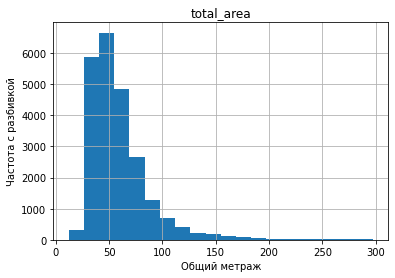

In [48]:
data['total_area'].hist(bins=20) 
plt.xlabel('Общий метраж') 
plt.ylabel('Частота с разбивкой') 
plt.title("total_area")
plt.show()

The most common apartments with a footage of 50 square meters, data without emissions, fit perfectly into the current state of affairs in the Russian real estate market.

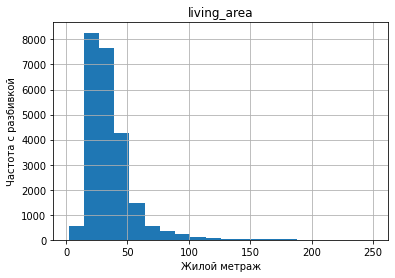

In [49]:
data['living_area'].hist(bins=20) 
plt.xlabel('Жилой метраж') 
plt.ylabel('Частота с разбивкой') 
plt.title("living_area")
plt.show()

Unfortunately, the sample contains the most apartments with a living area of up to 50 square meters - and most often there are apartments where the living area is 20-35 square meters - this is about 1-2 rooms in a standard apartment in a five-story building, which are also the most common.

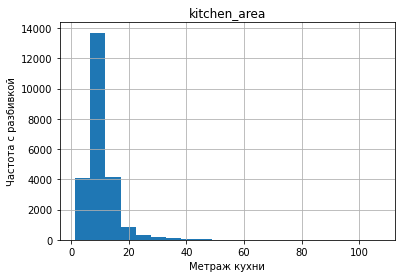

In [50]:
data['kitchen_area'].hist(bins=20) 
plt.xlabel('Метраж кухни') 
plt.ylabel('Частота с разбивкой') 
plt.title("kitchen_area")
plt.show()

The situation is the same with the size of the kitchen - it is most often 10 square meters - almost the size of a standardized loggia or a little more than a balcony, if there is one at all.

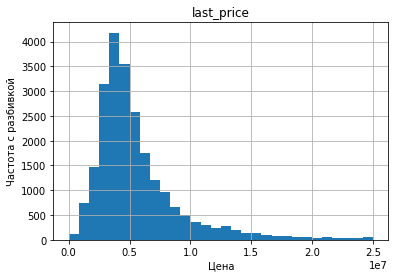

In [51]:
(data['last_price']).hist(bins=30, range=(0,25000000)) 
plt.xlabel('Цена') 
plt.ylabel('Частота с разбивкой') 
plt.title("last_price")
plt.show()

Most often there are apartments that are sold for a price of about 5 million rubles - this may be due to the distance from the city center, settlement, the size of the apartment and other factors not indicated in the table.

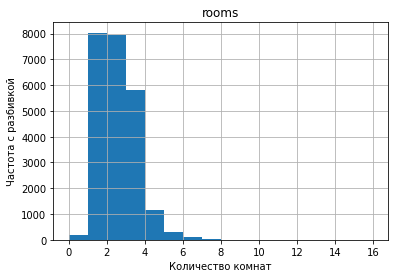

In [52]:
data['rooms'].hist(bins=data['rooms'].max()) 
plt.xlabel('Количество комнат') 
plt.ylabel('Частота с разбивкой') 
plt.title("rooms")
plt.show()

Most often there are apartments from 1 to 3 rooms - which is almost the absolute standard of apartments in Russia. Outliers are also normal - 4-room apartments exist, but they are less popular. In any case, the number of rooms correlates with the total footage.

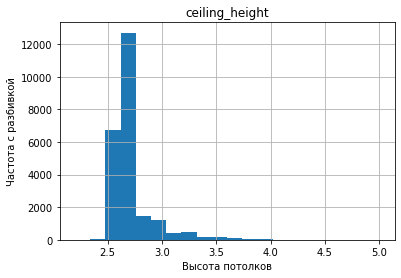

In [53]:
data['ceiling_height'].hist(bins=20) 
plt.xlabel('Высота потолков') 
plt.ylabel('Частота с разбивкой') 
plt.title("ceiling_height")
plt.show()

As previously mentioned, the average ceiling height in Russia is 3 meters - what we see from the graph - the most common apartments with ceiling heights from 2.5 to 3 meters. For example, this figure may be higher in Germany, because there are more old houses preserved, where ceiling heights can reach 5 meters.

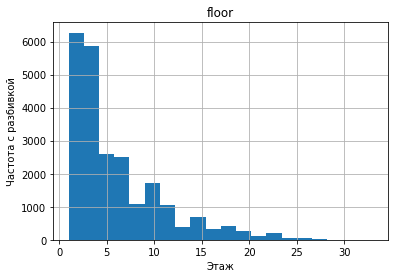

In [54]:
data['floor'].hist(bins=20) 
plt.xlabel('Этаж') 
plt.ylabel('Частота с разбивкой') 
plt.title("floor")
plt.show()

Most of the floors are in the area up to 5 floors - this is easily explained by the fact that five-story buildings are one of the most common objects in the country.

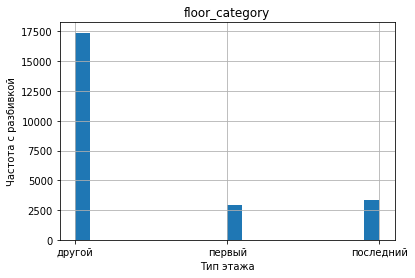

In [55]:
data['floor_category'].hist(bins=20) 
plt.xlabel('Тип этажа') 
plt.ylabel('Частота с разбивкой') 
plt.title("floor_category")
plt.show()

Most of the floors are in the "other" category - which is logical, because there cannot be less of them than the first or last floors.

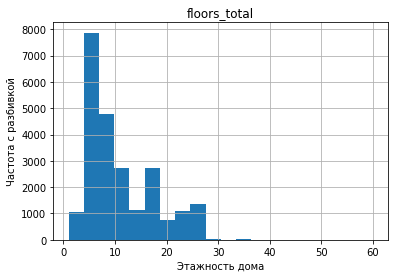

In [56]:
data['floors_total'].hist(bins=20) 
plt.xlabel('Этажность дома') 
plt.ylabel('Частота с разбивкой') 
plt.title("floors_total")
plt.show()

Here the situation is the same as with the floor of the apartment - most often there are floors in the area from 5 to 10th.

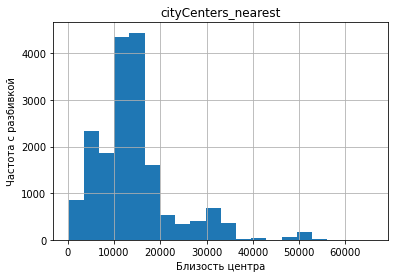

In [57]:
data['cityCenters_nearest'].hist(bins=20) 
plt.xlabel('Близость центра') 
plt.ylabel('Частота с разбивкой') 
plt.title("cityCenters_nearest")
plt.show()

Quite a few apartments are located closer than the city center (which city?) less than 10 kilometers away - mostly the center is at least 10 kilometers away and further.

In addition to this, the sample is extremely low compared to the total number of lines - more than 50% of empty lines.

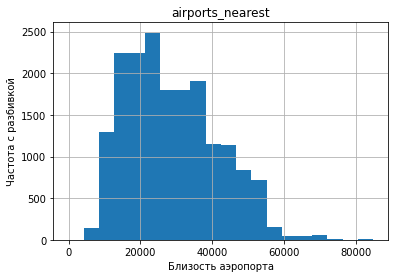

In [58]:
data['airports_nearest'].hist(bins=20) 
plt.xlabel('Близость аэропорта') 
plt.ylabel('Частота с разбивкой') 
plt.title("airports_nearest")
plt.show()

The distribution by distance from the airport is smoother - probably due to the fact that airports of neighboring regions can be taken into account if the point is located on the border.

This may also be due to the fact that many apartments are located far from the city center, which means they are closer to the city border, and, accordingly, the airport.

In addition to this, the sample is extremely low compared to the total number of lines - more than 50% of empty lines.

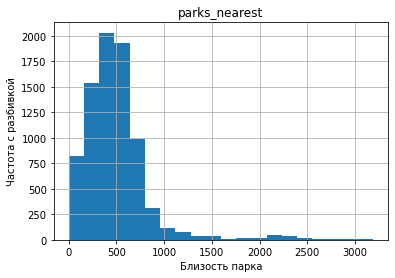

In [59]:
data['parks_nearest'].hist(bins=20) 
plt.xlabel('Близость парка') 
plt.ylabel('Частота с разбивкой') 
plt.title("parks_nearest")
plt.show()

We do not have information about how far the parks are not within a radius of 3000 meters - this may mean that there are no nearest parks further than 3 km, or that people did not enter this information - more than 50% of the lines are empty. We could use map data from the internet to fill in this data, as long as we have at least the apartment's zip code.

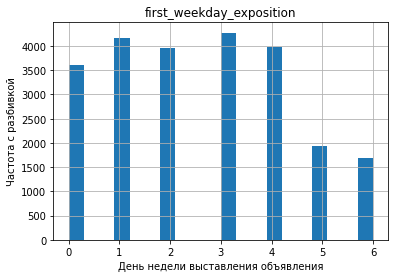

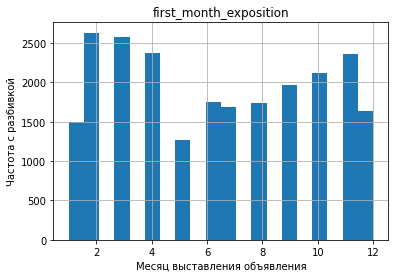

In [60]:
data['first_weekday_exposition'].hist(bins=20) 
plt.xlabel('День недели выставления объявления') 
plt.ylabel('Частота с разбивкой') 
plt.title("first_weekday_exposition")
plt.show()

data['first_month_exposition'].hist(bins=20) 
plt.xlabel('Месяц выставления объявления') 
plt.ylabel('Частота с разбивкой') 
plt.title("first_month_exposition")
plt.show()

There is an approximate dependence of the frequency of placing ads on the days of the week and on the month, but the histogram is not the most visual graph for this data.

We see an increase in the number of ads for the sale of apartments. There can be many reasons for this - the data from the table is not enough for an accurate answer:
1) placing ads on the Internet has become more popular over time\
2) people began to buy larger apartments and therefore sell current ones\
3) people had to sell their apartment due to the crisis (post 2014) and move to a cheaper place\
4) people began to move to larger cities - from the village to somewhere else\
5) and other reasons that are difficult to identify with the current data set.

#### How fast are apartments being sold

Среднее: 185.60227032064043
Медиана: 94.0


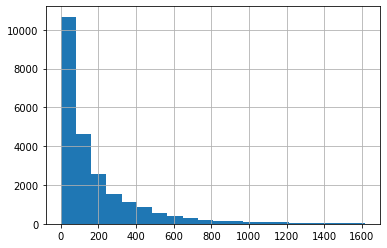

In [61]:
print('Среднее:', data['days_exposition'].mean())
print('Медиана:', data['days_exposition'].median())
data['days_exposition'].hist(bins=20) 
plt.show()

Usually an object is sold in 100 days, or approximately 3.5 months.\
If the object was sold within 200-240 days, the sale can be considered fast, after a year - not very normal, and sales longer than a year can already be considered unreasonably long. There can be many reasons - from location to price (and sometimes with an inverse correlation - an apartment in the center for 200 million will be waiting for a buyer for a long time).

#### What affects the price the most

First, let's check the correlation - most likely, for the living area and the area of the apartment it will be similar to the total area - because they are included in the living area.

In [62]:
data[['last_price','total_area', 'living_area', 'kitchen_area', 'rooms']].corr()

,last_price,total_area,living_area,kitchen_area,rooms
last_price,1.000000,0.675148,0.587337,0.513147,0.393903
total_area,0.675148,1.000000,0.928968,0.593527,0.785057
living_area,0.587337,0.928968,1.000000,0.399155,0.852454
kitchen_area,0.513147,0.593527,0.399155,1.000000,0.257037
rooms,0.393903,0.785057,0.852454,0.257037,1.000000


In [63]:
price_tarea_pivot = data.pivot_table(index = 'total_area', values = 'last_price', aggfunc = 'median')
price_larea_pivot = data.pivot_table(index = 'living_area', values = 'last_price', aggfunc = 'median')
price_karea_pivot = data.pivot_table(index = 'kitchen_area', values = 'last_price', aggfunc = 'median')
price_room_pivot = data.pivot_table(index = 'rooms', values = 'last_price', aggfunc = 'median')
price_weekd_pivot = data.pivot_table(index = 'first_weekday_exposition', values = 'last_price', aggfunc = 'median')
price_month_pivot = data.pivot_table(index = 'first_month_exposition', values = 'last_price', aggfunc = 'median')
price_year_pivot = data.pivot_table(index = 'first_year_exposition', values = 'last_price', aggfunc = 'median')
price_floor_pivot = data.pivot_table(index = 'floor_category', values = 'last_price', aggfunc = 'median')

array([<AxesSubplot:xlabel='kitchen_area'>], dtype=object)

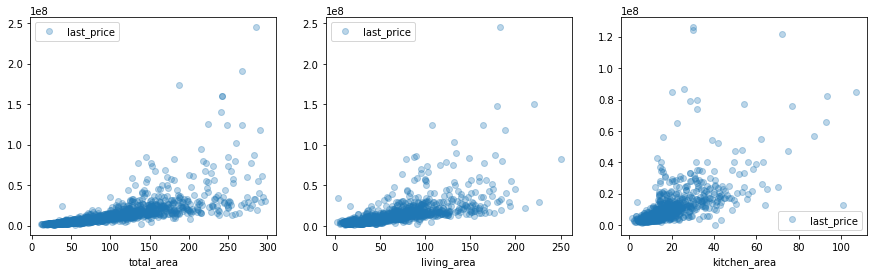

In [64]:
fig, axes1 = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
# plot first pandas frame in subplot style
price_tarea_pivot.plot(ax = axes1[0],subplots=True, style='o', alpha = 0.3) 
# plot second pandas frame in subplot style
price_larea_pivot.plot(ax = axes1[1],subplots=True, style='o', alpha = 0.3)
# plot third pandas frame in subplot style
price_karea_pivot.plot(ax = axes1[2],subplots=True, style='o', alpha = 0.3)

The price directly depends on the flat size - but the sizes also depends on each other. Therefore, you can only use the total_area indicator to say that the larger the apartment, the higher the price - and the progression is smooth - due to the fact that the price per square meter does not change much with increasing footage. It depends more on the location.

array([<AxesSubplot:xlabel='first_year_exposition'>], dtype=object)

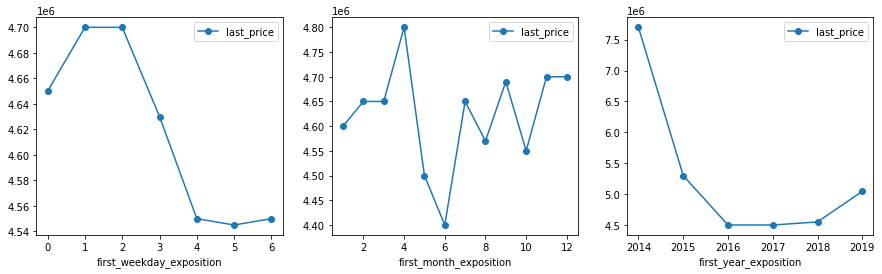

In [65]:
fig, axes2 = plt.subplots(nrows=1,ncols=3,figsize=(15,4))
# plot first pandas frame in subplot style
price_weekd_pivot.plot(ax = axes2[0],subplots=True, style='o-') 
# plot second pandas frame in subplot style
price_month_pivot.plot(ax = axes2[1],subplots=True, style='o-') 
# plot third pandas frame in subplot style
price_year_pivot.plot(ax = axes2[2],subplots=True, style='o-') 

1) Day of the week - at the beginning of the week the price rises, in the middle of the week it starts to fall, and at the end of the week it reaches a plateau. But this may not depend on the day of the week, but on the time the ad is posted, depending on the location. What does this mean:\
- Working people (not pensioners, for example) may not have time to put up an apartment for sale by themselves during weekdays - we can assume that there are more working people in St. Petersburg - but when they do put up an apartment, they do not reduce the price in relation to to other ads/
- Unemployed people can advertise all week - and most likely they are dumping the price hoping that it will sell faster - or the size of their apartments does not allow them to put a higher price.
As a result, we cannot say that the dependence is exclusively in the day of the week, but the dependence is visible, it's just not the only one.
 
2) Month - we see that at the beginning of the school holidays, the apartments offered are cheaper - but there is no direct dependence on the month of the offer. Jumps are too frequent and scattered.

3) Year of exposure - a smooth line symbolizes a direct relationship. At first, apartment prices fell, then they stayed at the same level, and by 2019 they began to increase - this coincides with the economic cycles - a fall, a drop, an increase. The economic crisis of 2014 lasted for about 5 years, which we can see on the graph of the annual change in the price of apartments.

array([<AxesSubplot:xlabel='rooms'>], dtype=object)

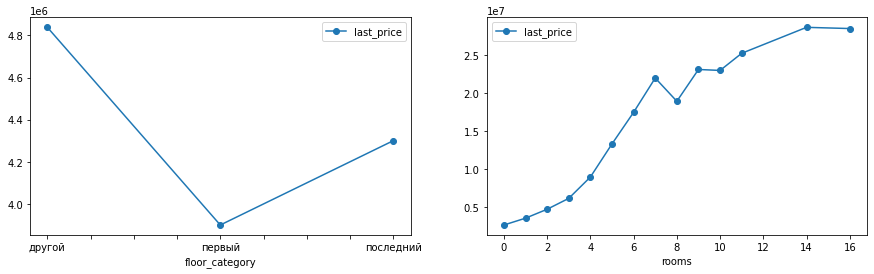

In [66]:
fig, axes3 = plt.subplots(nrows=1,ncols=2,figsize=(15,4))
# plot first pandas frame in subplot style
price_floor_pivot.plot(ax = axes3[0],subplots=True, style='o-') 
# plot second pandas frame in subplot style
price_room_pivot.plot(ax = axes3[1],subplots=True, style='o-')

1) Floor - the dependence is not visible - there are statistically less first and last floors than others, so the graph is not informative.\
2) The number of rooms - as in the case of the total footage, the dependence is direct - and it is worth paying attention to the beginning of the graph, because the most common apartments are 2-4 room apartments.

Total: the most powerful influences on the price:
1) Total footage, in connection with this, the number of rooms, kitchen footage and living footage.\
2) Day of the week\
3) Year - not the year itself affects the price, but the events that occurred in a certain time period.

#### The most often occuring locations with the cheapest and most expensive meter square.

In [67]:
most_posts = data.groupby('locality_name').agg({'last_price':['count'],'price_per_sqm':['median']})
most_posts.columns = ['count', 'median_sqm_price']
most_posts = most_posts.sort_values(by = 'count', ascending = False).head(10)
print(most_posts)

                 count  median_sqm_price
locality_name                           
Санкт-Петербург  15647     104729.729730
Мурино             590      86175.643522
Кудрово            471      95762.711864
Шушары             440      76876.172608
Всеволожск         397      65789.473684
Пушкин             367     100000.000000
Колпино            337      74722.222222
Парголово          327      91642.857143
Гатчина            307      67796.610169
Выборг             235      58307.692308


We have identified the settlements with the largest number of ads - 10 pieces. Now we need to find the most expensive and cheapest square meter among these settlements and display the points themselves.

In [68]:
print('The cheapest meter is in:', most_posts.loc[most_posts['median_sqm_price'] == most_posts['median_sqm_price'].min()].index.values)
print('The most expensive meter is in:', most_posts.loc[most_posts['median_sqm_price'] == most_posts['median_sqm_price'].max()].index.values)
print('Average square meter price:', most_posts['median_sqm_price'].mean().astype('int'))

The cheapest meter is in: ['Выборг']
The most expensive meter is in: ['Санкт-Петербург']
Average square meter price: 82180


It is quite logical that the most expensive square meter is in St. Petersburg. The cheapest one is in Vyborg.

#### The center of Saints-Petersburg.

count        18.102000
mean       1257.651086
std        6764.890548
min           1.328466
25%         264.410647
50%         396.356368
75%         812.595454
max      364678.899083
Name: price_per_center_km, dtype: float64
1430511.4260355064
447523.56036221166


<AxesSubplot:xlabel='city_centers_nearest_km'>

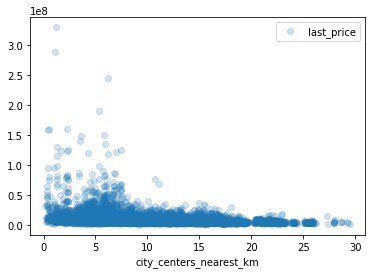

In [69]:
data['price_per_center_km'] = ((data['last_price']) / data['city_centers_nearest_km'])
print(data['price_per_center_km'].describe()/1000) # деление на 1000 чтобы убрать scientific notation
print(data.loc[data['locality_name'] == 'Санкт-Петербург', 'price_per_center_km'].mean())
print(data.loc[data['locality_name'] == 'Санкт-Петербург', 'price_per_center_km'].median())

data[data['locality_name'] == 'Санкт-Петербург'].plot(x='city_centers_nearest_km',y='last_price',style='o', alpha = 0.2)

The relative dependence of the price on the location near the center of St. Petersburg is noticeable - but it is not direct. In short, a distance of more than 7-8 kilometers from the center does not affect the price in any way. Getting closer does not have an absolute dependence, but we notice some positions that increase sharply in price - in principle, everything that is almost near the center and 5 kilometers from it has the same direct dependence.\
Most likely, the absence of direct dependence is connected with the state of the city. The center of St. Petersburg was not repaired at the same pace as the center of Moscow - many buildings are in emergency condition, the streets are poorly cleaned in winter, and in principle the budget of the second capital is different. Therefore, there is no desire to live in the center of St. Petersburg, and because of this, prices do not increase in proportion to proximity to the center.

### Conclusion

#### Data information

1) Problems of initial data. There is not enough data in the table to draw more detailed conclusions:
- there is not a lot of data on distances - gaps in 20-40% of the lines
- points of reference of distances are not given - from the center of which city? From which airport?
- no address / zip code / longitude and latitude of accommodation. Together with the distance reference point, we could have filled in the distance data ourselves
- the dimensions of the living area and kitchen, the height of the ceilings are not filled
- no filling by type of apartment, free planning
- for unclosed positions there is no indication of how long the ad has been published for - this must be counted depending on the date of the data download. In this case, you must also add the column "Sold / Not sold"
- city names are not the same - this could also be solved by having a house ZIP

2) According to the comments above, following needs to be added:
- ZIP column or other geographical designation of the location
- Column 'Sold / Not sold'
- Reference point of distances - nearest parks, lakes, airports, city center - in the title columns or separate ones(if the point is different)
- Building type - new or not
- Building level - premium / normal or other indicators
- If it has been renovated or not
- Availability of parking

#### Task conclusion

'Your job is to set the parameters. This will allow an automated system to be built to track anomalies and fraudulent activity.'

We need to understand what we mean by fraudulent activity. If this is an attempt at money laundering or other cases of illegal transactions, we will have to pay attention to the extremely low price per square meter for apartments located, for example, in the very center of the city, or the extremely high price per square meter for unfavorably located apartments.

array([<AxesSubplot:xlabel='price_per_sqm'>], dtype=object)

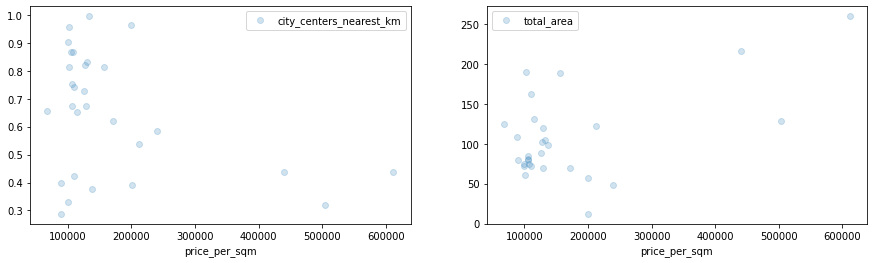

In [70]:
fig, axes4 = plt.subplots(nrows=1,ncols=2,figsize=(15,4))

data[(data['locality_name'] == 'Санкт-Петербург') & (data['city_centers_nearest_km'] < 1) &(data['first_year_exposition'] == 2017)].plot(x='price_per_sqm',y='city_centers_nearest_km',style='o', alpha = 0.2, ax = axes4[0],subplots=True)
data[(data['locality_name'] == 'Санкт-Петербург') & (data['city_centers_nearest_km'] < 1) &(data['first_year_exposition'] == 2017)].plot(x='price_per_sqm',y='total_area',style='o', alpha = 0.2, ax = axes4[1],subplots=True)

For example, if you take the graph above, you might think that the value of 160 million rubles is suspiciously sticking out - but it is also the largest proposal in terms of area.\
But the lowest value on the right graph, about 200,000 rubles per square meter, does look suspicious - it stands out from the general group in terms of footage, and the second value on the same straight line (about 200K per square meter) is already within the logical range - moreover, the group from 50 to 100 square meters is evenly spaced from the center, but has about the same price, and this particular value is more expensive for less footage and being within 500 meters from the center.

In [71]:
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['city_centers_nearest_km'] < 1) & (data['first_year_exposition'] == 2017) & (195000 < data['price_per_sqm'])]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_type_city,total_area_categories,last_day_exposition,price_per_sqm,first_weekday_exposition,first_month_exposition,first_year_exposition,city_centers_nearest_km,floor_category,price_per_center_km
492,18,95000000.0,216.0,2017-12-05,4,3.00,5,86.0,4,False,...,True,1,2017-12-19,439814.814815,1,12,2017,0.436,другой,2.178899e+08
7744,16,11500000.0,48.0,2017-12-02,1,3.70,5,25.0,3,False,...,True,7,2018-03-25,239583.333333,5,12,2017,0.583,другой,1.972556e+07
13919,12,65000000.0,129.0,2017-09-25,3,2.65,6,72.0,5,False,...,True,3,2017-10-08,503875.968992,0,9,2017,0.318,другой,2.044025e+08
16495,12,159000000.0,260.0,2017-04-04,4,2.65,5,180.0,4,False,...,True,1,2017-09-29,611538.461538,1,4,2017,0.436,другой,3.646789e+08
17078,20,11500000.0,57.4,2017-07-24,1,4.25,6,37.5,3,False,...,True,6,2018-10-18,200348.432056,0,7,2017,0.392,другой,2.933673e+07
17521,17,26000000.0,122.4,2017-08-25,4,2.65,5,71.0,5,False,...,True,3,2018-04-27,212418.300654,4,8,2017,0.537,последний,4.841713e+07
19904,4,2400000.0,12.0,2017-07-19,1,2.55,5,10.0,2,False,...,True,10,2018-02-04,200000.000000,2,7,2017,0.964,другой,2.489627e+06


Our line is the last one. Why is this apartment so expensive - it is farther from the center than everything in the sample, and also with the lowest ceilings. For further analysis, we will already need to view the photo, maybe even call the owner.

In principle, any apartments whose cost per square meter differs by more than 30% from the average / median in a particular city can be considered as potentially suspicious. But as we have already seen above, this is influenced by the "uniqueness" factor - large apartments in the center, for example, are rare, and you can ask more for them. That is why a detailed analysis of indicators requires more of the auxiliary columns indicated above.

#### Finalisation

A lot of factors influence the price. The main ones are listed in the graphs and summary tables above - footage (the larger the footage, the more expensive the apartment), location (the closer to the center, the more expensive), city (large cities are more expensive). There are many small additional factors - but they apply to apartments above the average level.

To determine fraud, in addition to the difference from the average price per square meter, you can also take the speed of selling an apartment - it is extremely difficult to sell an apartment in a month if it is not absolutely ideal in all respects, including price. But usually people sell an apartment for the price they want, not the buyers.